In [1]:
import cv2
from PIL import Image
import random
import os, glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn

from torchvision import transforms, datasets
import torch.optim as optim
import torch.nn.functional as F

from tqdm.autonotebook import tqdm

C:\Users\user\AppData\Local\Temp\ipykernel_12472\1938900093.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
device = 'cpu' # 학습시 gpu 사용을 결정, (cuda : gpu 사용, cpu : cpu 사용)
batch_size = 32 # batch size 결정
num_workers = 4 # gpu 사용 시 사용 효율과 관련됨. 무조건 크다고 좋지 않음, system 의존
lr = 1e-3 # learning rate
momentum = 0.9 # optimizer momentum parameter
weight_decay = 1e-5 # weight decay rate
EPOCH = 3 # train epoch
n_steps = 10000

In [4]:
from torch.utils.data import DataLoader, RandomSampler

"""
Image Resize & array to tensor & 증강
train set에만 적용한다. 
test는 unseen 이라고 가정되기때문에 어떤 변화든 줄 수 없음.
"""
data_transforms = {
    'train': transforms.Compose([
    transforms.Resize((128, 128)), #image resize
    transforms.RandomHorizontalFlip(), # image Horizontal Flip 
    transforms.RandomChoice([
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.2), # color transform
        transforms.RandomResizedCrop(128), 
        transforms.RandomAffine(
            degrees=5, translate=(0.5, 0.5),
            scale=(0.8, 1.0), shear=5) # random 하게 이미지 변형
    ]),
    transforms.ToTensor(), # tensor type으로 변경
    transforms.Normalize((0.4452, 0.4457, 0.4464), (0.2592, 0.2596, 0.2600)), # image normalize
]),
    'test': transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.4452, 0.4457, 0.4464), (0.2592, 0.2596, 0.2600)),
])
}

# torch datasets 사용하여 image folder로부터 dataset 객체를 생성한다.
train_dataset = datasets.ImageFolder('dataset/train', transform=data_transforms['train'])
# test_dataset = datasets.ImageFolder('dataset/test', transform=data_transforms['test'])

# dataset 에서 data를 어떻게 sampling 할지 결정함.

sampler = RandomSampler(train_dataset,
                        replacement=True,
                        num_samples=batch_size * n_steps)


# 실제 학습 시 dataset에서 batch 단위로 갖고오도록 하는 DataLoader 를 생성하여 
# 이전에 설정한 dataset, sampler를 인자로 넣어준다.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                              sampler=sampler, num_workers=num_workers, shuffle=False)

# test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
#                              shuffle=False, num_workers=num_workers)


print(len(train_dataset)) # b , 3, 64, 64
# print(len(test_dataset))

90


Size of train set: 90
Input shape: torch.Size([3, 128, 128])
Label: 0


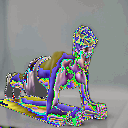

In [5]:
# Let's take a look at train dataset
# 임의의 index를 부여하여 dataset 내 image가 어떻게 변경이 되었는지 확인한다.
print(f"Size of train set: {len(train_dataset)}")
index = 0
x, y = train_dataset[index]
print(f"Input shape: {x.shape}")
print(f"Label: {y}")

transforms.functional.to_pil_image(x)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        """
            latent_dim : VAE의 잠재 변수, 원 data를 재구성하기 위한 잠재 정보. 
                        클수록 복잡도 증가, tuning을 통해 최적값 찾아야함
            
            Auto Encoder의 구조와 같이 encoder, decoder로 구성되어있음.
            encoder 에는 conv layer, Decoder에는 convtranspose 를 사용하여 이미지 차원을 축소하조 다시 원상복귀시키는 구조
            
        """
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 256, 4, 2, 1), #128
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, 4, 2, 1), # 64
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 1024, 4, 2, 1), # 32
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 2048, 4, 2, 1), # 16
            nn.BatchNorm2d(2048),
            nn.ReLU(),
            nn.Conv2d(2048, 2048, 4, 2, 1), # 8
            nn.BatchNorm2d(2048),
            nn.ReLU(),
            nn.Flatten()
        )
        
        n_channels = self.encoder(torch.empty(1, 3, 128,128)).size(-1)
        
        
        self.enc_out = nn.Sequential(
            nn.Linear(n_channels, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 256),
            nn.ReLU(True),
            nn.Linear(256, latent_dim * 2))
        

        self.decoder = nn.Sequential(
                    nn.Linear(latent_dim, 256),
                    nn.ReLU(),
                    nn.Linear(256, 1024),
                    nn.ReLU(),
                    nn.Linear(1024, 2048),
                    nn.ReLU(),
                    nn.Linear(2048, 2048),
                    nn.ReLU(),
                    nn.Unflatten(1, (2048, 1, 1)),  # 1x1x2048로 reshape
                    # 아래 ConvTransposed2d를 사용하여 img 원 사이즈로 승강 시킨다.
                    nn.ConvTranspose2d(2048, 2048, 4, 2, 1), # 2
                    nn.ReLU(True),
                    nn.ConvTranspose2d(2048, 1024, 4, 2, 1), # 4
                    nn.ReLU(True),
                    nn.ConvTranspose2d(1024, 512, 4, 2, 1), # 8
                    nn.ReLU(True), 
                    nn.ConvTranspose2d(512, 256, 4, 2, 1), # 16
                    nn.ReLU(True),
                    nn.ConvTranspose2d(256, 128, 4, 2, 1), # 32
                    nn.ReLU(True),
                    nn.ConvTranspose2d(128, 64, 4, 2, 1), # 64
                    nn.ReLU(True),
                    nn.ConvTranspose2d(64, 3, 4, 2, 1), # 128
                    nn.Sigmoid()
                )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x_enc = self.encoder(x)
        mu, logvar = self.enc_out(x_enc).chunk(2, dim=1) # enc network 출력을 두개 tensor로 나눈다. 
        z = self.reparameterize(mu, logvar) # 위에서 구한 mu, logvar 화률 분포를 토대로 sampling된 잠재변수 z
        x_recon = self.decoder(z) # 
        return x_recon, mu, logvar

# 모델 학습
# latent_dim 40으로 설정
model = VAE(latent_dim=40).to(device)
# optimizer 생성
# Adam 사용, learning rate, weight_decay 등 위에서 설정한 parameter 적용한다.
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
# Train scheduler 설정, cosine Annealing 방식으로 learning rate에 주기를 부여한다.
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

# EPOCH & step 1 epoch 당 10000개의 step 존재
# 500 Step 당 loss 확인,
for epoch in range(EPOCH):
    total_loss = 0
    for step, (x, y) in enumerate(tqdm(train_dataloader), start=1):
        model.train()
        x= x.to(device)
        optimizer.zero_grad()
        x_recon, mu, logvar = model(x)
        # KL Divergence Loss 구한다. 원본과 생성 이미지 간의 유사도 
        loss = torch.mean(torch.pow(x - x_recon, 2)) + torch.mean(torch.exp(logvar) + mu**2 - 1 - logvar)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
        # Summary & Eval
        if step % 500 == 0:
            print(f"[Step {step}] train_loss: {loss.detach().squeeze():.2f}")
    print('Epoch [{}/{}], Loss: {:.4f}'.format(EPOCH+1, num_epochs, total_loss / len(train_dataloader)))



  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
torch.save(model.state_dict(), './vae_model.pt')

In [ ]:

model.load_state_dict(torch.load('vae_model.pt'))  # 모델 경로와 파일 이름에 맞게 수정



In [ ]:
# 이상 탐지 수행
model.eval()

threshold = 0.01  # 이상치 판별 임계값

with torch.no_grad():
    anomaly_count = 0
    for data, _ in test_loader:
        data = data.to(device)
        x_hat, mean, log_var = model(data)
        loss = nn.functional.binary_cross_entropy(x_hat, data, reduction='mean')
        if loss > threshold:
            anomaly_count += 1

print("이상치 개수:", anomaly_count)